In [1]:
# loading necessary libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, AdamW
from keras.utils import plot_model
import tensorboard
keras.utils.set_random_seed(844)

import pandas as pd
import geopandas as gpd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from joblib import dump, load
import pickle
import json
from rasterio import plot
import os

import ee
import geemap
import rasterio as rio
from tqdm.notebook import tqdm
from datetime import datetime

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from libs.ee_utils import Utilities as utils
from libs.ee_featuregeneration import FeatureGeneration
from libs.ee_utils import Utilities as utils

In [2]:
GEE_SERVICE_ACC = 'kjr-eej-jahid@ee-kazijahid.iam.gserviceaccount.com'
GEE_CREDS = "D:/3. Projects/dash/ds4rs_main_app/ee-kazijahid-f8bb3244119c.json"
collection_name = 'COPERNICUS/S2_SR_HARMONIZED'
mgrs_tile_no = '48PVT'
from_year = 2024
to_year = 2024
from_month = 1
to_month = 4
maximum_cloud = 2
dark_feature_percenatge = 2
selectedbands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

# location of area of interest shape file in your storage
saving_dir = '2024'
band_saving_dir = f'./Data/{saving_dir}/Bands/'
plots_saving_dir = f'./Data/{saving_dir}/Plots/'
grids_saving_dir = f'./Data/{saving_dir}/Grids/'
best_model_saving_dir = f'./Data/{saving_dir}/Models/'
outputs_path = f'./Data/{saving_dir}/Outputs/'
aoi_path = "./Data/Inputs/MyAOI_32648.shp"
train_samples_path = "./Data/Inputs/TrainingData(Corrected)_2.shp"
test_samples_path = "./Data/Inputs/TestData(Corrected)_2.shp"

In [3]:
utils.loadEE(GEE_SERVICE_ACC, GEE_CREDS)


# If you do not have a GEE Credential, remove the above line and uncomment the below lines
# ee.Authenticate()
# # Initialize the library.
# ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

'Authentication successful'

In [4]:
# Search the images from GEE archive
trainingImage, trainingImageprojection, trainingImagecrs, trainingImagetransform_image = utils.loadTrainingImage(collection_name, mgrs_tile_no, aoi_path, from_year, from_month, to_year, to_month, maximum_cloud, dark_feature_percenatge )

# To fill the cloud masked pixels
fillerImage = utils.loadFillerImage(collection_name, mgrs_tile_no, aoi_path, from_year, from_month, to_year, to_month, trainingImageprojection )

# Preprocessing
trainingImage = utils.preprocessImage(trainingImage, fillerImage)

#Clipping, Selecting Bands for aoi
trainingImage, trainingImageprojection, trainingImagecrs, trainingImagetransform  = utils.trimImage(trainingImage, aoi_path, selectedbands)
trainingImageID = trainingImage.id().getInfo()

# Creating the dirs
os.makedirs(band_saving_dir, exist_ok=True)
os.makedirs(plots_saving_dir, exist_ok=True)
os.makedirs(grids_saving_dir, exist_ok=True)
os.makedirs(best_model_saving_dir, exist_ok=True)
os.makedirs(outputs_path, exist_ok=True)

# Visualising the images
Map = geemap.Map()
Map.addLayer(trainingImage, {'bands':['B4', 'B3','B2'],'min':0, 'max':10000, 'gamma':[3,3,3]}, 'TrainingImage')
Map.centerObject(trainingImage.geometry())
Map

Image Used for filler image: 13
Preprocessing Completed. Returning the processed image...
Clipping and Band selection completed. Returning trimmed image


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

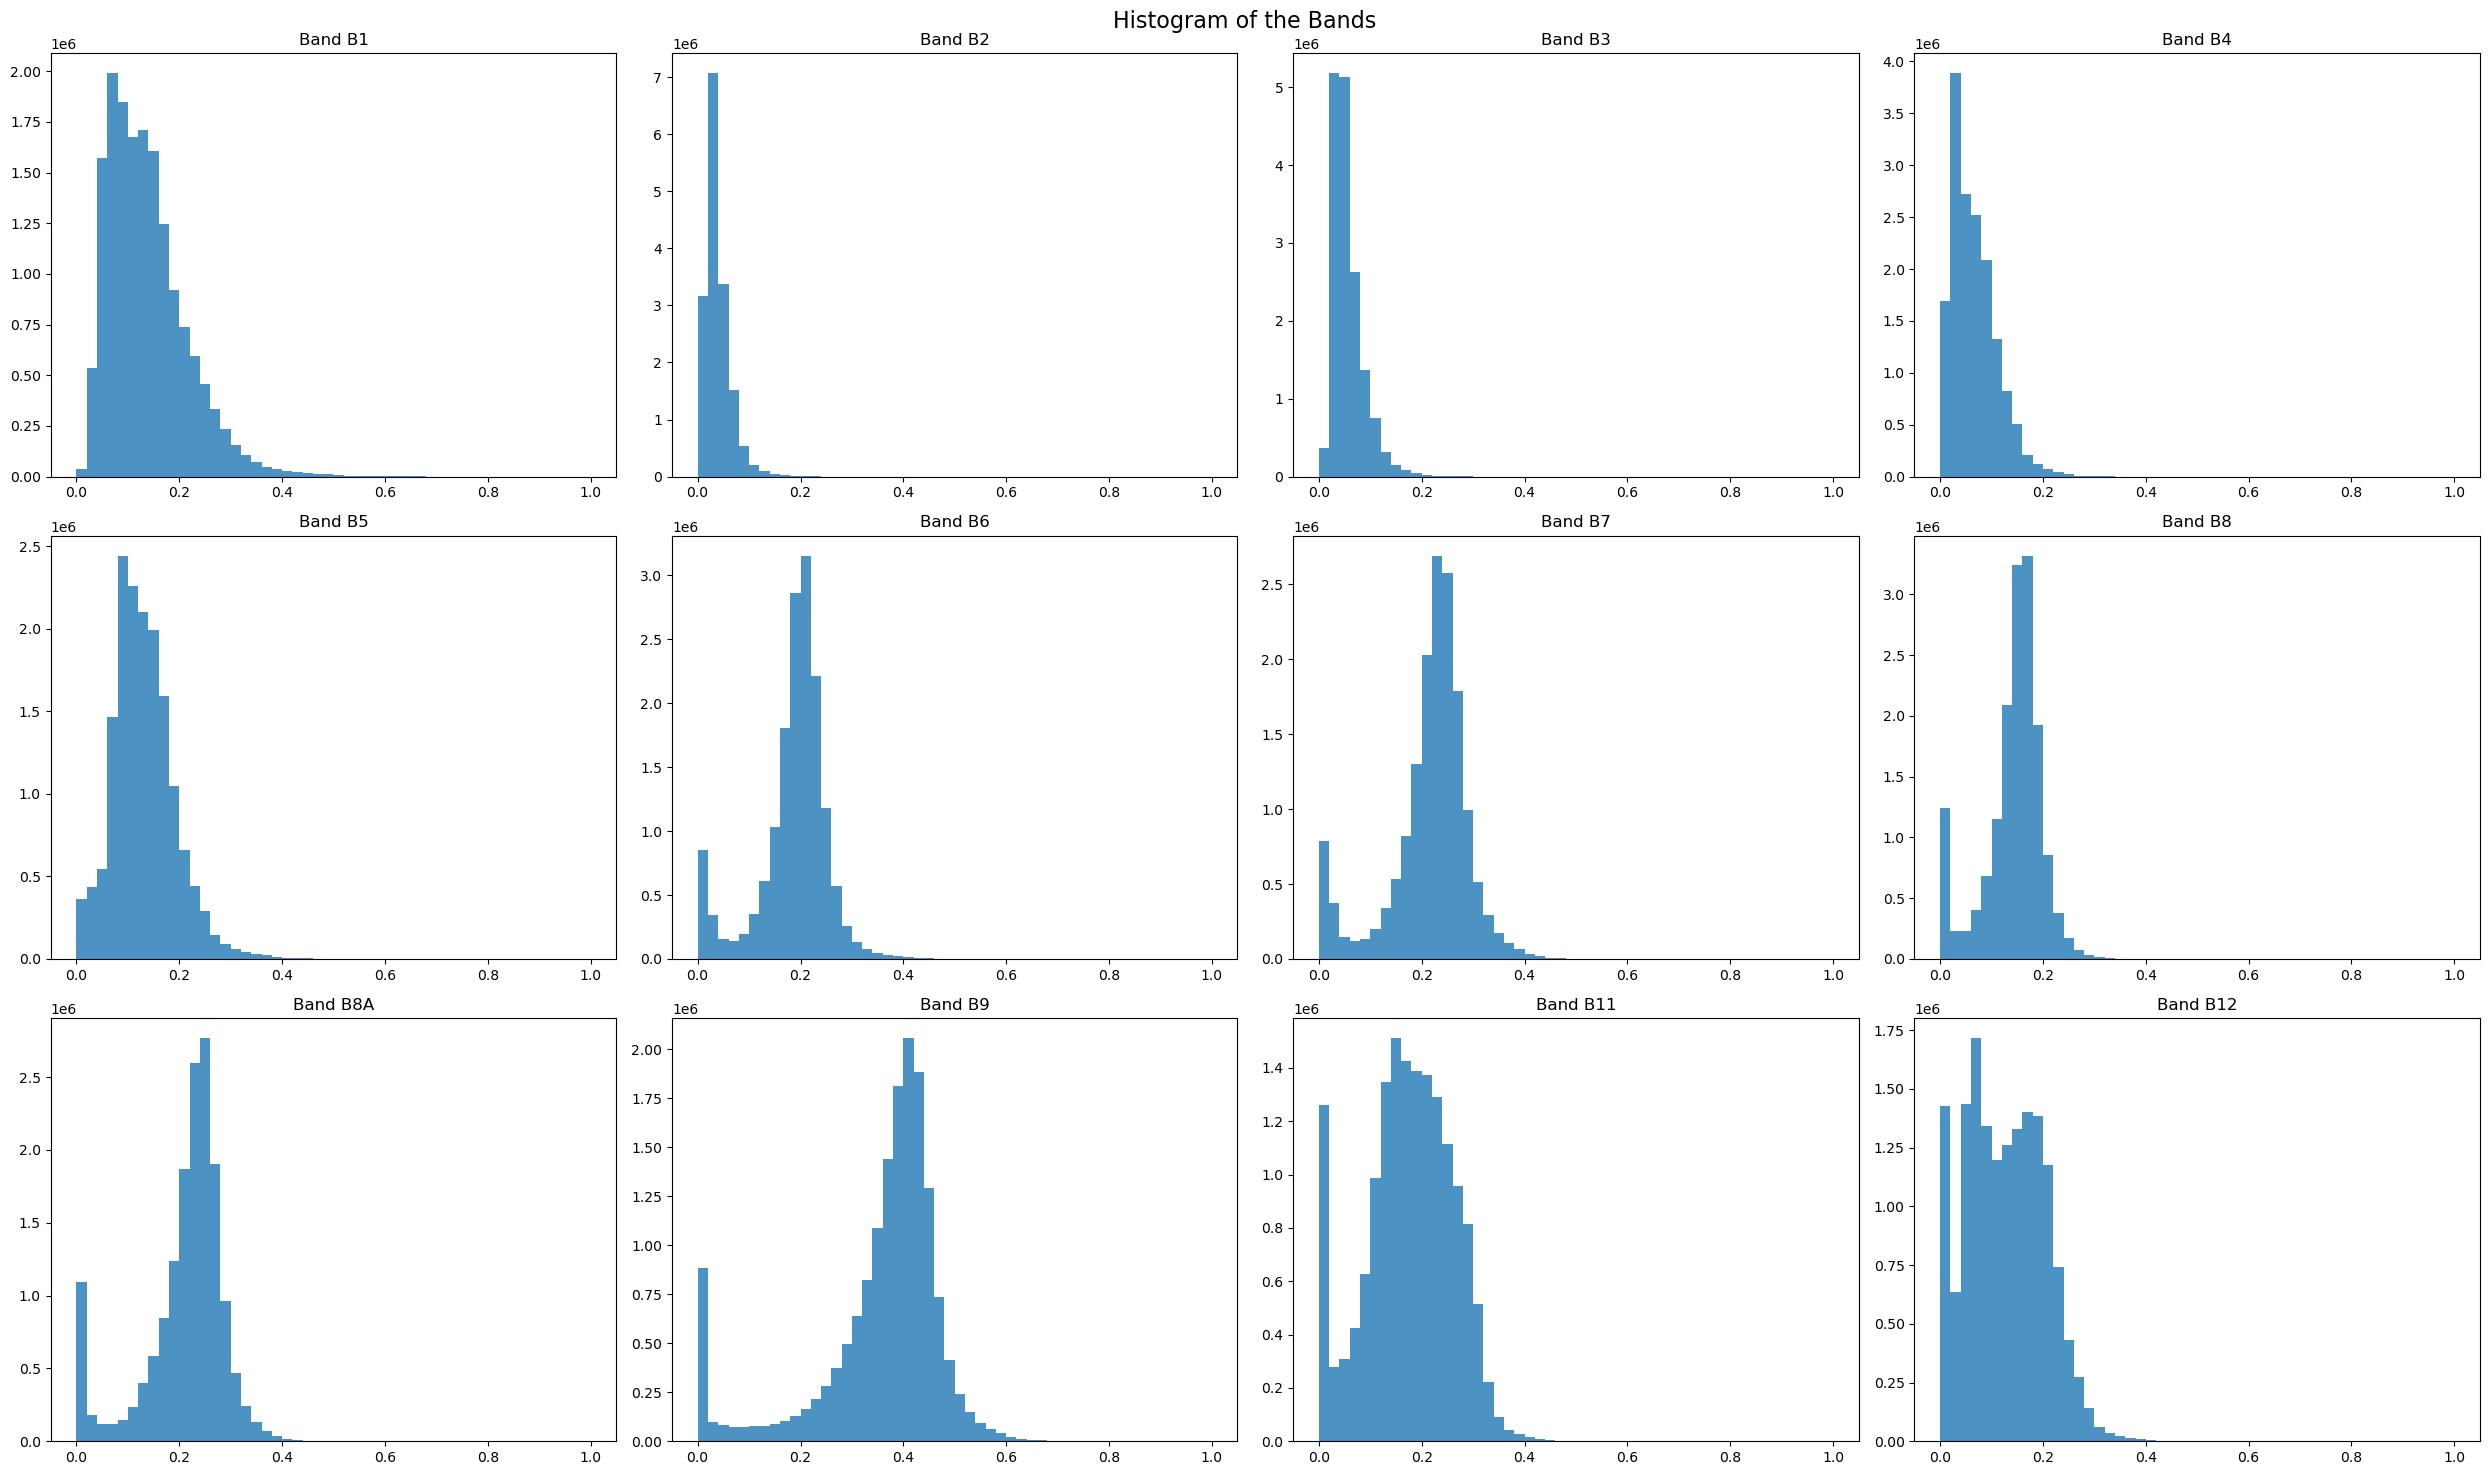

In [5]:
# Download data, to download uncomment the first line after this line
# exportedFolder = utils.downloadBands(trainingImage, selectedbands, aoi_path, band_saving_dir, 10)

exportedFolder = f'{band_saving_dir}/{trainingImageID}/'
BandData, BandsAffineTransform, BandsCrs = utils.loadBands(export_path =exportedFolder, selectedbands = selectedbands )
# Normalizing the bands
BandData = utils.normalize(BandData)


# Plotting the normalized bands
num_bands = len(BandData)
num_rows = (num_bands + 3) // 4
fig, axs = plt.subplots(num_rows, 4, figsize=(25, 5 * num_rows))
selectedbands = selectedbands[:num_bands]  # Ensure that the number of selected bands is within the available bands

for idx, band in enumerate(selectedbands):
    band_array = BandData[idx]
    rowidx = idx // 4
    colidx = idx % 4
    ax = axs[rowidx, colidx]
    ax.hist(band_array.flatten(), bins=50, lw=0.0, stacked=False, alpha=0.8)
    ax.set_title(f"Band {band}")
    
if num_bands < num_rows * 4:
    for i in range(num_bands, num_rows * 4):
        axs.flatten()[i].axis('off')
plt.suptitle('Histogram of the Bands', fontsize=16)
plt.tight_layout()
plt.show()
fig.savefig(f"{plots_saving_dir}Bands_Histograms.png", bbox_inches='tight')

In [6]:
# Calculating the indices
ndbi = FeatureGeneration.functn_Ndbi(SWIR = BandData[10], NIR = BandData[7]) # in sentinel 2  B11 is SWIR and B8 is NIR,
ndwi = FeatureGeneration.functn_Ndwi(GREEN = BandData[2], NIR = BandData[7])  # in sentinel 2 B3 is Green and B8 is NIR
ndvi = FeatureGeneration.functn_Ndvi(NIR = BandData[7], RED = BandData[3])  # In Sentinel 2 B8 is NIR and B4 is Red
bsi = FeatureGeneration.functn_Bsi( BLUE =  BandData[1], RED =  BandData[3], NIR =  BandData[7], SWIR2 = BandData[11])

# Saving the caluclated indices
utils.save_geotiff(data = ndbi, crs = BandsCrs, transform=BandsAffineTransform, output_path=exportedFolder + "NDBI.tif")
utils.save_geotiff(data=ndwi, crs=BandsCrs, transform=BandsAffineTransform, output_path=exportedFolder + "NDWI.tif")
utils.save_geotiff(data=ndvi, crs=BandsCrs, transform= BandsAffineTransform, output_path=exportedFolder + "NDVI.tif")
utils.save_geotiff(data=bsi, crs=BandsCrs, transform=BandsAffineTransform, output_path=exportedFolder + "BSI.tif")

# Creating the final datasets, 2 datasets first with only bands, second with 4 extra indices
bandsDataNoIndex = np.asarray(BandData)
bandsDataNoIndex = np.nan_to_num(bandsDataNoIndex, nan=0.0, posinf=0.0, neginf=0.0)

bandsData4Index = np.asarray(BandData+[ndbi,ndwi,ndvi,bsi])
bandsData4Index = np.nan_to_num(bandsData4Index, nan=0.0, posinf=0.0, neginf=0.0)
selectedbands = selectedbands+['NDBI','NDWI','NDVI','BSI']

# Load spectral values for all training and testing samples
trainingDataset, trainingData, trainingLabel = utils.loadTrainTestData(bandsData4Index, selectedbands,  train_samples_path, BandsAffineTransform, BandsCrs)
testingDataset, testingData, testingLabel = utils.loadTrainTestData(bandsData4Index, selectedbands,  test_samples_path, BandsAffineTransform, BandsCrs)

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 5690.24it/s]


In [7]:
# Preparing the dataset and labels for the model
trainDataNoIndice=[]
trainLabelNoIndice=[]
testDataNoIndice=[]
testLabelNoIndice=[]

trainData4Indice=[]
trainLabel4Indice=[]
testData4Indice=[]
testLabel4Indice=[]
NumOfClasses=len(testingDataset.c_number.unique())

for i in range(NumOfClasses):
    training_Data_class_i_NoIndice=trainingDataset[trainingDataset["c_number"]==i][['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']].values
    training_Labels_class_i_NoIndice=trainingDataset[trainingDataset["c_number"]==i]["c_number"]
   
    training_Data_class_i_4Indice=trainingDataset[trainingDataset["c_number"]==i][['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12','NDBI','NDWI','NDVI','BSI']].values
    training_Labels_class_i_4Indice=trainingDataset[trainingDataset["c_number"]==i]["c_number"]

    testing_Data_class_i_NoIndice=testingDataset[testingDataset["c_number"]==i][['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']].values
    testing_Labels_class_i_NoIndice=testingDataset[testingDataset["c_number"]==i]["c_number"]

    testing_Data_class_i_4Indice=testingDataset[testingDataset["c_number"]==i][['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12','NDBI','NDWI','NDVI','BSI']].values
    testing_Labels_class_i_4indice=testingDataset[testingDataset["c_number"]==i]["c_number"]


    trainDataNoIndice.extend(training_Data_class_i_NoIndice)
    trainLabelNoIndice.extend(training_Labels_class_i_NoIndice)
    testDataNoIndice.extend(testing_Data_class_i_NoIndice)
    testLabelNoIndice.extend(testing_Labels_class_i_NoIndice)

    trainData4Indice.extend(training_Data_class_i_4Indice)
    trainLabel4Indice.extend(training_Labels_class_i_4Indice)
    testData4Indice.extend(testing_Data_class_i_4Indice)
    testLabel4Indice.extend(testing_Labels_class_i_4indice)

    print('Class',i)
    print(f'Training Data-Label No Indices Shape {training_Data_class_i_NoIndice.shape}, {training_Labels_class_i_NoIndice.shape}')
    print(f'Testing Data-Label No Indices Shape {testing_Data_class_i_NoIndice.shape} , {testing_Labels_class_i_NoIndice.shape, }')

    print(f'Training Data-Label 4 Indices Shape {training_Data_class_i_4Indice.shape}, {training_Labels_class_i_4Indice.shape}')
    print(f'Testing Data-Label 4 Indices Shape {testing_Data_class_i_4Indice.shape} , {testing_Labels_class_i_4indice.shape, }')

trainDataNoIndice=np.array(trainDataNoIndice)
testDataNoIndice=np.array(testDataNoIndice)
trainLabelNoIndice=np.array(trainLabelNoIndice)
testLabelNoIndice=np.array(testLabelNoIndice)

trainData4Indice=np.array(trainData4Indice)
testData4Indice=np.array(testData4Indice)
trainLabel4Indice=np.array(trainLabel4Indice)
testLabel4Indice=np.array(testLabel4Indice)

# Shuffle the data while maintaining correspondence
trainDataNoIndice, trainLabelNoIndice = shuffle(trainDataNoIndice, trainLabelNoIndice, random_state=6)
testDataNoIndice, testLabelNoIndice = shuffle(testDataNoIndice, testLabelNoIndice, random_state=6)

trainData4Indice, trainLabel4Indice = shuffle(trainData4Indice, trainLabel4Indice, random_state=6)
testData4Indice, testLabel4Indice = shuffle(testData4Indice, testLabel4Indice, random_state=6)

Class 0
Training Data-Label No Indices Shape (306, 12), (306,)
Testing Data-Label No Indices Shape (117, 12) , ((117,),)
Training Data-Label 4 Indices Shape (306, 16), (306,)
Testing Data-Label 4 Indices Shape (117, 16) , ((117,),)
Class 1
Training Data-Label No Indices Shape (308, 12), (308,)
Testing Data-Label No Indices Shape (104, 12) , ((104,),)
Training Data-Label 4 Indices Shape (308, 16), (308,)
Testing Data-Label 4 Indices Shape (104, 16) , ((104,),)
Class 2
Training Data-Label No Indices Shape (321, 12), (321,)
Testing Data-Label No Indices Shape (117, 12) , ((117,),)
Training Data-Label 4 Indices Shape (321, 16), (321,)
Testing Data-Label 4 Indices Shape (117, 16) , ((117,),)
Class 3
Training Data-Label No Indices Shape (308, 12), (308,)
Testing Data-Label No Indices Shape (131, 12) , ((131,),)
Training Data-Label 4 Indices Shape (308, 16), (308,)
Testing Data-Label 4 Indices Shape (131, 16) , ((131,),)
Class 4
Training Data-Label No Indices Shape (393, 12), (393,)
Testing D

**Training and Fitting Model - Random Forest**

In [8]:
# Preparing the dataset for RF
trainData_RF_NoIndice = np.array(trainDataNoIndice)
testData_RF_NoIndice = np.array(testDataNoIndice)
trainLabel_RF_NoIndice = keras.utils.to_categorical(trainLabelNoIndice)
testLabel_RF_NoIndice = keras.utils.to_categorical(testLabelNoIndice)

trainData_RF_4Indice = np.array(trainData4Indice)
testData_RF_4Indice = np.array(testData4Indice)
trainLabel_RF_4Indice = keras.utils.to_categorical(trainLabel4Indice)
testLabel_RF_4Indice = keras.utils.to_categorical(testLabel4Indice)

# defining parameter distribution for random search
ParamDistribution_RF = {'n_estimators': [200, 500, 1000, 1500],'criterion': ['gini', 'entropy', 'log_loss']}

In [17]:
# '''This section is used for hyperparameter tuning. Beaware It is time consuming.'''
# # Define and train the grids and save them, Uncomment below lines if want to run. Beware it's time consuming

# RF_Grid_WithNoIndices= GridSearchCV(RandomForestClassifier(random_state=9),ParamDistribution_RF, refit = True, verbose = 3,
#                                     cv=2).fit(trainData_RF_NoIndice, trainLabel_RF_NoIndice)
# # accessing the best model and its hyperparameters
# RF_Grid_WithINoIndices_BestModel = RF_Grid_WithNoIndices.best_estimator_
# RF_Grid_WithNoIndices_BestParams = RF_Grid_WithNoIndices.best_params_

# # evaluating the best models on the test data
# RF_accuracyNoIndices = RF_Grid_WithINoIndices_BestModel.score(testData_RF_NoIndice, testLabel_RF_NoIndice)
# print("The classification accuracy for NoIndice is {:.4f}".format(RF_accuracyNoIndices))

# RF_Grid_With4Indices= GridSearchCV(RandomForestClassifier(random_state=9), ParamDistribution_RF, refit = True, verbose = 3,
#                                    cv=2).fit(trainData_RF_4Indice, trainLabel_RF_4Indice)
# RF_Grid_WithI4Indices_BestModel = RF_Grid_With4Indices.best_estimator_
# RF_Grid_With4Indices_BestParams = RF_Grid_With4Indices.best_params_

# RF_accuracy4Indices = RF_Grid_WithI4Indices_BestModel.score(testData_RF_4Indice, testLabel_RF_4Indice)
# print("The classification accuracy for 4 Indice is {:.4f}".format(RF_accuracy4Indices))

# Saving the complete grid, will be needed for the time complexity computation
# dump(RF_Grid_WithNoIndices, f'{grids_saving_dir}RF_Grid_WithNoIndices_CompleteGrid_{trainingImageID}.pkl')
# dump(RF_Grid_With4Indices, f'{grids_saving_dir}RF_Grid_With4Indices_CompleteGrid_{trainingImageID}.pkl')


# # Saving the model
# dump(RF_Grid_WithINoIndices_BestModel, f'{best_model_saving_dir}RF_WithNoIndicesGrid_BestModel_{trainingImageID}.joblib')
# dump(RF_Grid_WithI4Indices_BestModel, f'{best_model_saving_dir}RF_With4IndicesGrid_BestModel_{trainingImageID}.joblib')

['./Data/2024/Models/RF_With4IndicesGrid_BestModel_20240130T031959_20240130T033123_T48PVT.joblib']

The classification accuracy of RF for No Indices is 0.7963

The classification accuracy of RF for 4 Indices is 0.7963

Classification Report for Loaded_RFBestModelWithNoIndices
                      precision    recall  f1-score   support

TreeFloodedOtherVegi       0.60      0.91      0.72       117
RoadsOtherImpervious       0.94      0.93      0.94       104
           Grassland       0.79      0.56      0.65       117
            Building       0.95      0.82      0.88       131
               Water       0.98      0.96      0.97       114
         Agriculture       0.69      0.64      0.66       116
            BareLand       0.89      0.92      0.90       101

            accuracy                           0.82       800
           macro avg       0.83      0.82      0.82       800
        weighted avg       0.83      0.82      0.82       800

Classification Report for Loaded_RFBestModelWith4Indices
                      precision    recall  f1-score   support

TreeFloodedOtherVe

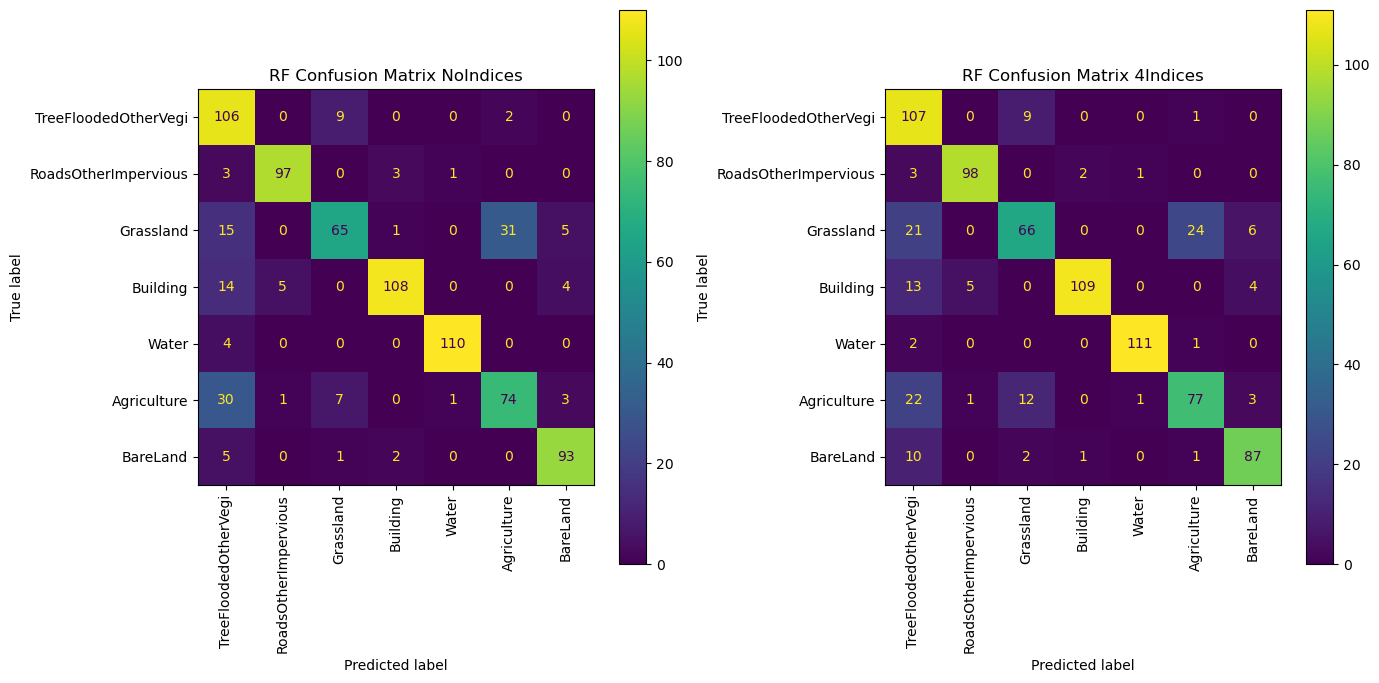

In [19]:
# Loading the trained grids and models
Loaded_RFGridWithNoIndices = load(f'{grids_saving_dir}RF_Grid_WithNoIndices_CompleteGrid_{trainingImageID}.pkl')
Loaded_RFGridWith4Indices = load(f'{grids_saving_dir}RF_Grid_With4Indices_CompleteGrid_{trainingImageID}.pkl')
Loaded_RFBestModelWithNoIndices = load(f'{best_model_saving_dir}RF_WithNoIndicesGrid_BestModel_{trainingImageID}.joblib')
Loaded_RFBestModelWith4Indices = load(f'{best_model_saving_dir}RF_With4IndicesGrid_BestModel_{trainingImageID}.joblib')

labels = ['TreeFloodedOtherVegi','RoadsOtherImpervious','Grassland','Building','Water', 'Agriculture', 'BareLand']
RF_accuracyNoIndices = Loaded_RFBestModelWithNoIndices.score(testData_RF_NoIndice, testLabel_RF_NoIndice)
RF_accuracy4Indices = Loaded_RFBestModelWith4Indices.score(testData_RF_4Indice, testLabel_RF_4Indice)
print("The classification accuracy of RF for No Indices is {:.4f}\n".format(RF_accuracyNoIndices))
print("The classification accuracy of RF for 4 Indices is {:.4f}\n".format(RF_accuracy4Indices))
TestPrediction_RFBestModelWithNoIndices = np.argmax(Loaded_RFBestModelWithNoIndices.predict(testData_RF_NoIndice), axis=1)
TestPrediction_RFBestModelWith4Indices = np.argmax(Loaded_RFBestModelWith4Indices.predict(testData_RF_4Indice), axis=1)
print('Classification Report for Loaded_RFBestModelWithNoIndices')
print(classification_report(np.argmax(testLabel_RF_NoIndice, axis=1), TestPrediction_RFBestModelWithNoIndices, target_names=labels))
print('Classification Report for Loaded_RFBestModelWith4Indices')
print(classification_report(np.argmax(testLabel_RF_4Indice,axis=1), TestPrediction_RFBestModelWith4Indices, target_names=labels))


# Generating the confusion matrices
ConfusionMatrix_RF_NoIndices = confusion_matrix(np.array(np.argmax(testLabel_RF_NoIndice, axis=1)), TestPrediction_RFBestModelWithNoIndices , labels=list(range(len(Loaded_RFBestModelWithNoIndices.classes_))))
ConfusionMatrix_RF_4Indices = confusion_matrix(np.array(np.argmax(testLabel_RF_4Indice, axis=1)), TestPrediction_RFBestModelWith4Indices , labels=list(range(len(Loaded_RFBestModelWith4Indices.classes_))))

fig, axs = plt.subplots(1, 2, figsize=(14,7))

# Plot each confusion matrix
ConfusionMatrixDisplay(confusion_matrix=ConfusionMatrix_RF_NoIndices, display_labels=labels).plot(ax=axs[0], xticks_rotation=90)
axs[0].set_title('RF Confusion Matrix NoIndices')

ConfusionMatrixDisplay(confusion_matrix=ConfusionMatrix_RF_4Indices, display_labels=labels).plot(ax=axs[1], xticks_rotation=90)
axs[1].set_title('RF Confusion Matrix 4Indices')

plt.tight_layout()
plt.show()
fig.savefig(f'{plots_saving_dir}RF Confusion Matrix', dpi=300)

Total Grid Elapsed time for No Index : 1.5651 minutes
Total Grid Elapsed time for 4 Index : 1.8591 minutes


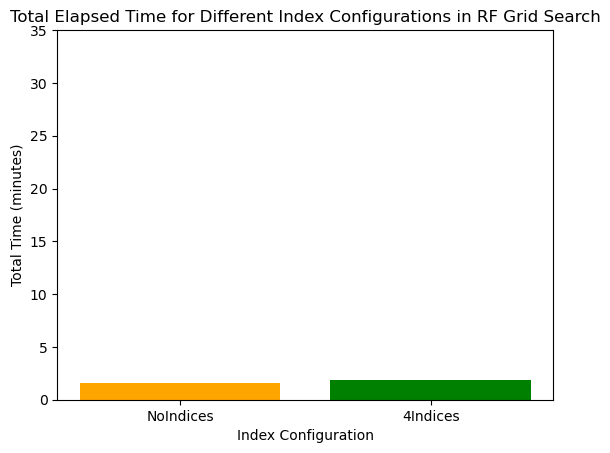

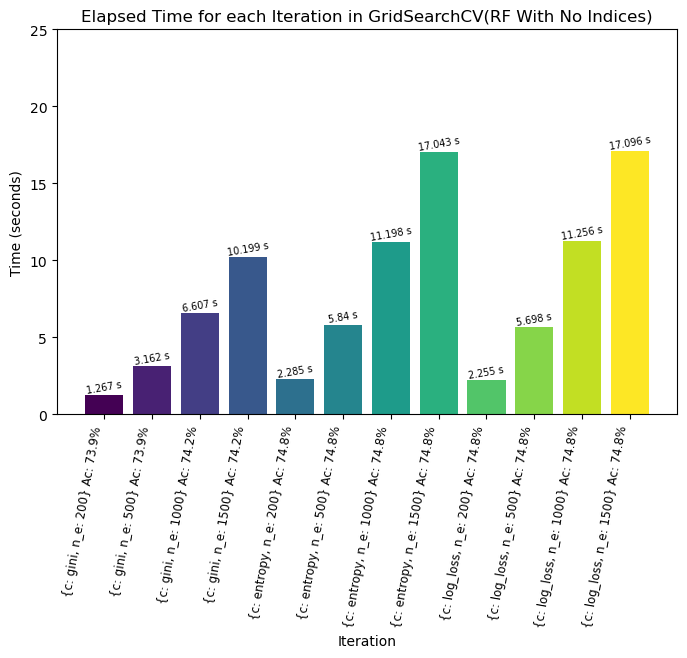

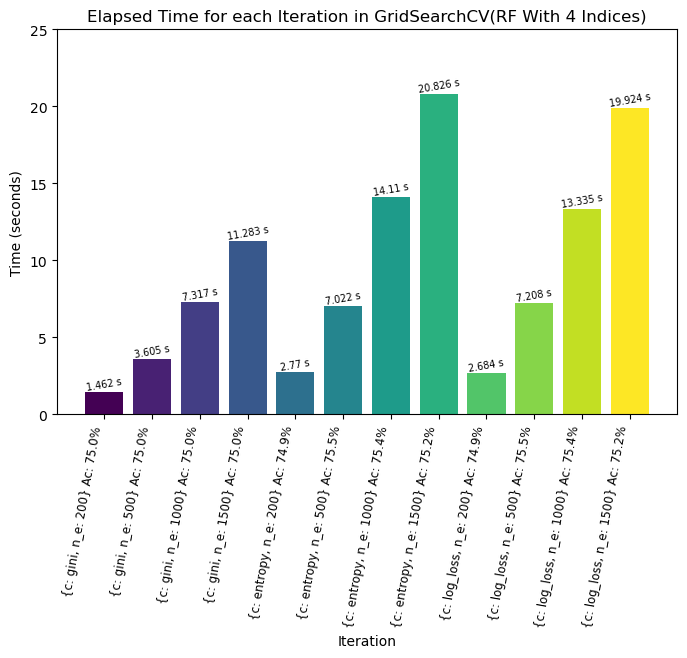

In [21]:
# Get the time taken for each iteration
ET_RFGridWithNoIndices = Loaded_RFGridWithNoIndices.cv_results_['mean_fit_time']
ET_RFGridWith4Indices = Loaded_RFGridWith4Indices.cv_results_['mean_fit_time']
Total_ET_RFGridWithNoIndices = Loaded_RFGridWithNoIndices.cv_results_['mean_fit_time'].sum()/60
Total_ET_RFGridWith4Indices = Loaded_RFGridWith4Indices.cv_results_['mean_fit_time'].sum()/60
print("Total Grid Elapsed time for No Index : {:.4f} minutes".format(Total_ET_RFGridWithNoIndices))
print("Total Grid Elapsed time for 4 Index : {:.4f} minutes".format(Total_ET_RFGridWith4Indices))
indices = ['NoIndices', '4Indices']

# Create a bar plot
total_elapsed_times = [Total_ET_RFGridWithNoIndices, Total_ET_RFGridWith4Indices]
bar_colors = ['Orange', 'green']
plt.bar(indices, total_elapsed_times, color=bar_colors)
plt.xlabel('Index Configuration')
plt.ylabel('Total Time (minutes)')
plt.title('Total Elapsed Time for Different Index Configurations in RF Grid Search')
plt.ylim(0, 35)
plt.savefig(f'{plots_saving_dir}RF Grids Elapsed Times.png', bbox_inches='tight')
plt.show()


plt.figure(figsize=(8, 5))
iteration_accuracies_RFNoindice = [round(item * 100, 1) for item in Loaded_RFGridWithNoIndices.cv_results_['mean_test_score']]
iteration_params_RFNoindice = [f"{param} Ac: {accuracy}%" for param, accuracy in zip(
    [str(item).replace('criterion', 'c').replace('n_estimators','n_e').replace("'","") for item in Loaded_RFGridWithNoIndices.cv_results_['params']],iteration_accuracies_RFNoindice)]
ET_RFGridWithNoIndices_Rounded = [round(item , 3) for item in ET_RFGridWithNoIndices]
plt.bar(iteration_params_RFNoindice, ET_RFGridWithNoIndices, color=plt.cm.viridis(np.linspace(0, 1, len(ET_RFGridWithNoIndices))))
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')
plt.title('Elapsed Time for each Iteration in GridSearchCV(RF With No Indices)')
plt.xticks(rotation=80, fontsize=8.5, ha='right')

for i, v in enumerate(ET_RFGridWithNoIndices_Rounded):
    plt.text(i, ET_RFGridWithNoIndices[i], str(v)+' s', ha='center', va='bottom', fontsize=7, rotation=10)
plt.ylim(0, 25)
plt.savefig(f'{plots_saving_dir}RF No Indices Individual Model Times.png', bbox_inches='tight')
plt.show()



plt.figure(figsize=(8, 5))
iteration_accuracies_RF4indice = [round(item * 100, 1) for item in Loaded_RFGridWith4Indices.cv_results_['mean_test_score']]
iteration_params_RF4indice = [f"{param} Ac: {accuracy}%" for param, accuracy in zip(
    [str(item).replace('criterion', 'c').replace('n_estimators','n_e').replace("'","") for item in Loaded_RFGridWith4Indices.cv_results_['params']],iteration_accuracies_RF4indice)]
ET_RFGridWith4Indices_Rounded = [round(item , 3) for item in ET_RFGridWith4Indices]
plt.bar(iteration_params_RF4indice, ET_RFGridWith4Indices, color=plt.cm.viridis(np.linspace(0, 1, len(ET_RFGridWith4Indices))))
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')
plt.title('Elapsed Time for each Iteration in GridSearchCV(RF With 4 Indices)')
plt.xticks(rotation=80, fontsize=8.5, ha='right')

for i, v in enumerate(ET_RFGridWith4Indices_Rounded):
    plt.text(i, ET_RFGridWith4Indices[i], str(v)+' s', ha='center', va='bottom', fontsize=7, rotation=10)
plt.ylim(0, 25)
plt.savefig(f'{plots_saving_dir}RF 4 Indices Individual Model Times.png', bbox_inches='tight')
plt.show()


In [22]:
'''This section is for classifying the whole image. Beaware that it is time consuming'''
imgPrediction_RF_NoIndices = utils.imagePrediction(Loaded_RFBestModelWithNoIndices, bandsDataNoIndex, 'RF')
imgPrediction_RF_4Indices = utils.imagePrediction(Loaded_RFBestModelWith4Indices, bandsData4Index, 'RF')
allRFImages = {'NoIndices': imgPrediction_RF_NoIndices,'4Indices': imgPrediction_RF_4Indices}

for name, rfimage in allRFImages.items():
    OutputFilePath_RF = f"{outputs_path}{trainingImageID}_RF_{name}Grid_classified.tif"
    with rio.open(OutputFilePath_RF, 'w', driver='GTiff', width=rfimage.shape[1],
                  height=rfimage.shape[0], count=1, crs=BandsCrs,
                  transform=BandsAffineTransform, dtype=np.uint8) as output:
        output.write(rfimage, 1)
    Image.fromarray(255*(rfimage==2).astype(np.uint8)).show()

  4%|███▎                                                                         | 171/4008 [04:37<1:43:46,  1.62s/it]


KeyboardInterrupt: 